In [1]:
import requests
import os
from PIL import Image


api_file_path = os.path.join('/home/hanrewan/', 'SentinelHub.api')
with open(api_file_path) as file:
    for row in file:
        api_key = row.replace('\n', '')
        break
    
url = "https://services.sentinel-hub.com/api/v1/process"
bounding_box = (36.801492, 37.128535, 37.487506, 37.610961)

In [2]:
from typing import Any, Optional, Tuple
from sentinelhub import SHConfig
import datetime
import os
import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

In [3]:
def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: Optional[Tuple[float, float]] = None, **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [4]:
config = SHConfig()
config.sh_client_id='a99936b5-2353-4d7e-9ce0-9be46f4a1921'
config.sh_client_secret=api_key
config.save()

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [5]:
def load_satelite_img(borders, resolution=60, date_from="2020-06-12", date_to="2020-07-13"):
    betsiboka_bbox = BBox(bbox=borders, crs=CRS.WGS84)
    betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)
    
    print(f"Image shape at {resolution} m resolution: {betsiboka_size} pixels")
    okay = input("Continue? (Y, N): ")
    if okay != 'Y':
        return None
    
    evalscript_true_color = """
        //VERSION=3
    
        function setup() {
            return {
                input: [{
                    bands: ["B02", "B03", "B04"]
                }],
                output: {
                    bands: 3
                }
            };
        }
    
        function evaluatePixel(sample) {
            return [sample.B04, sample.B03, sample.B02];
        }
    """
    
    request_true_color = SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=(date_from, date_to),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=betsiboka_bbox,
        size=betsiboka_size,
        config=config,
    )

    return request_true_color.get_data()

In [6]:
true_color_imgs = load_satelite_img(bounding_box)

Image shape at 60 m resolution: (1030, 872) pixels


Continue? (Y, N):  Y


Image type: uint8


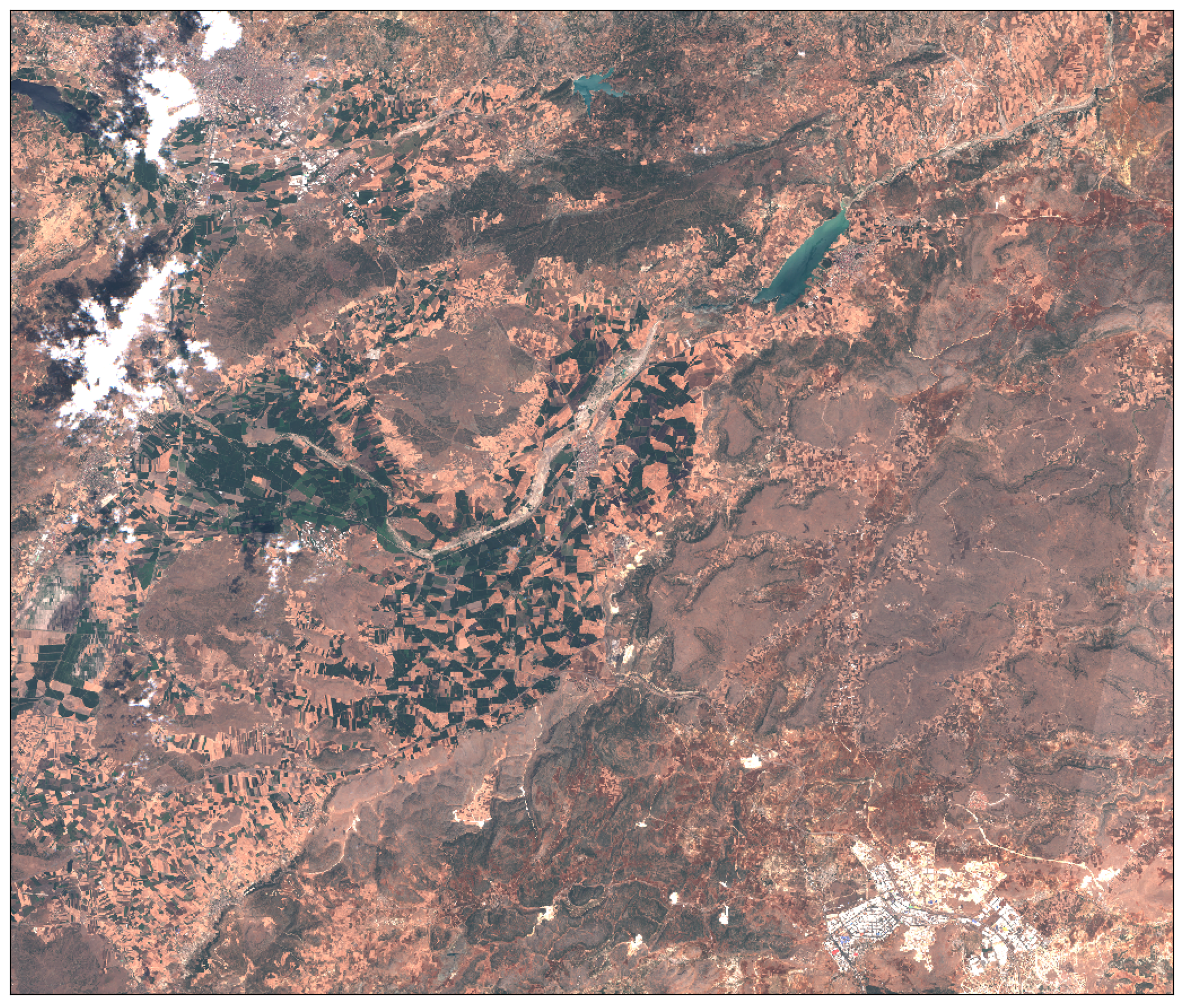

In [7]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

In [8]:
import imageio

output_path = 'output_image.tiff'
imageio.imsave(output_path, true_color_imgs[0])